<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
#!pip install --update numpy
#!pip install seaborn
import seaborn as sns
#######below was stock
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-12-19 02:29:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2020-12-19 02:29:07 (12.1 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

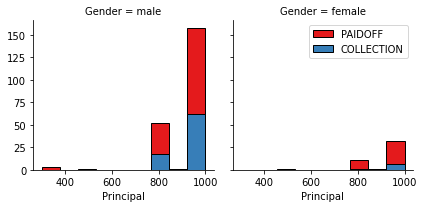

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

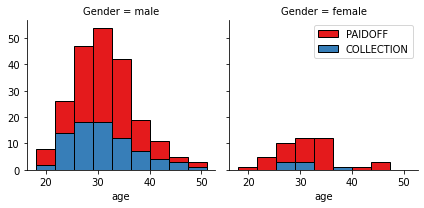

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

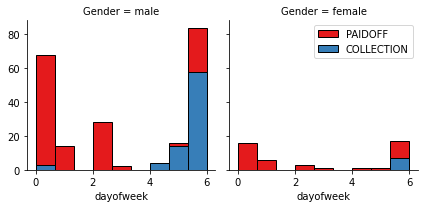

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

In [18]:
#df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


Lets defind feature sets, X:

In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,random_state=4)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

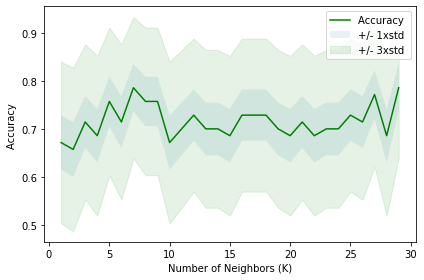

7 appears to be best in the chart. Confirmed by individual testing


In [24]:
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
#Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc,alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc,alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print('7 appears to be best in the chart. Confirmed by individual testing')

In [25]:
k = 27
#Train Model and Predict
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh
yhat = neigh.predict(X_test)
yhat[0:5]
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7572463768115942
Test set Accuracy:  0.7714285714285715


In [26]:
k = 7
#Train Model and Predict
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh
yhat = neigh.predict(X_test)
yhat[0:5]
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


# Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

In [28]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y,test_size=0.3, random_state=3)
print('Shape of X training set {}'.format(X_trainset.shape),'&',' Size of Y,training set {}'.format(y_trainset.shape))
print('Shape of X test set {}'.format(X_testset.shape),'&',' Size of Y test set {}'.format(y_testset.shape))

Shape of X training set (242, 8) &  Size of Y,training set (242,)
Shape of X test set (104, 8) &  Size of Y test set (104,)


In [29]:
LoanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 2)
LoanTree # it shows the default parameter
LoanTree.fit(X_trainset,y_trainset)
predTree = LoanTree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']
DecisionTrees's Accuracy:  0.7403846153846154


In [30]:
LoanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
LoanTree # it shows the default parameter
LoanTree.fit(X_trainset,y_trainset)
predTree = LoanTree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']
DecisionTrees's Accuracy:  0.6538461538461539


In [31]:
! pip install pydotplus graphviz
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
import collections
from sklearn.datasets import load_iris
%matplotlib inline

     |████████████████████████████████| 278 kB 16.2 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=4705ea7417eda90231937ca2b987b1938edb99c7c71bad9fb546ae923c279c5e
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


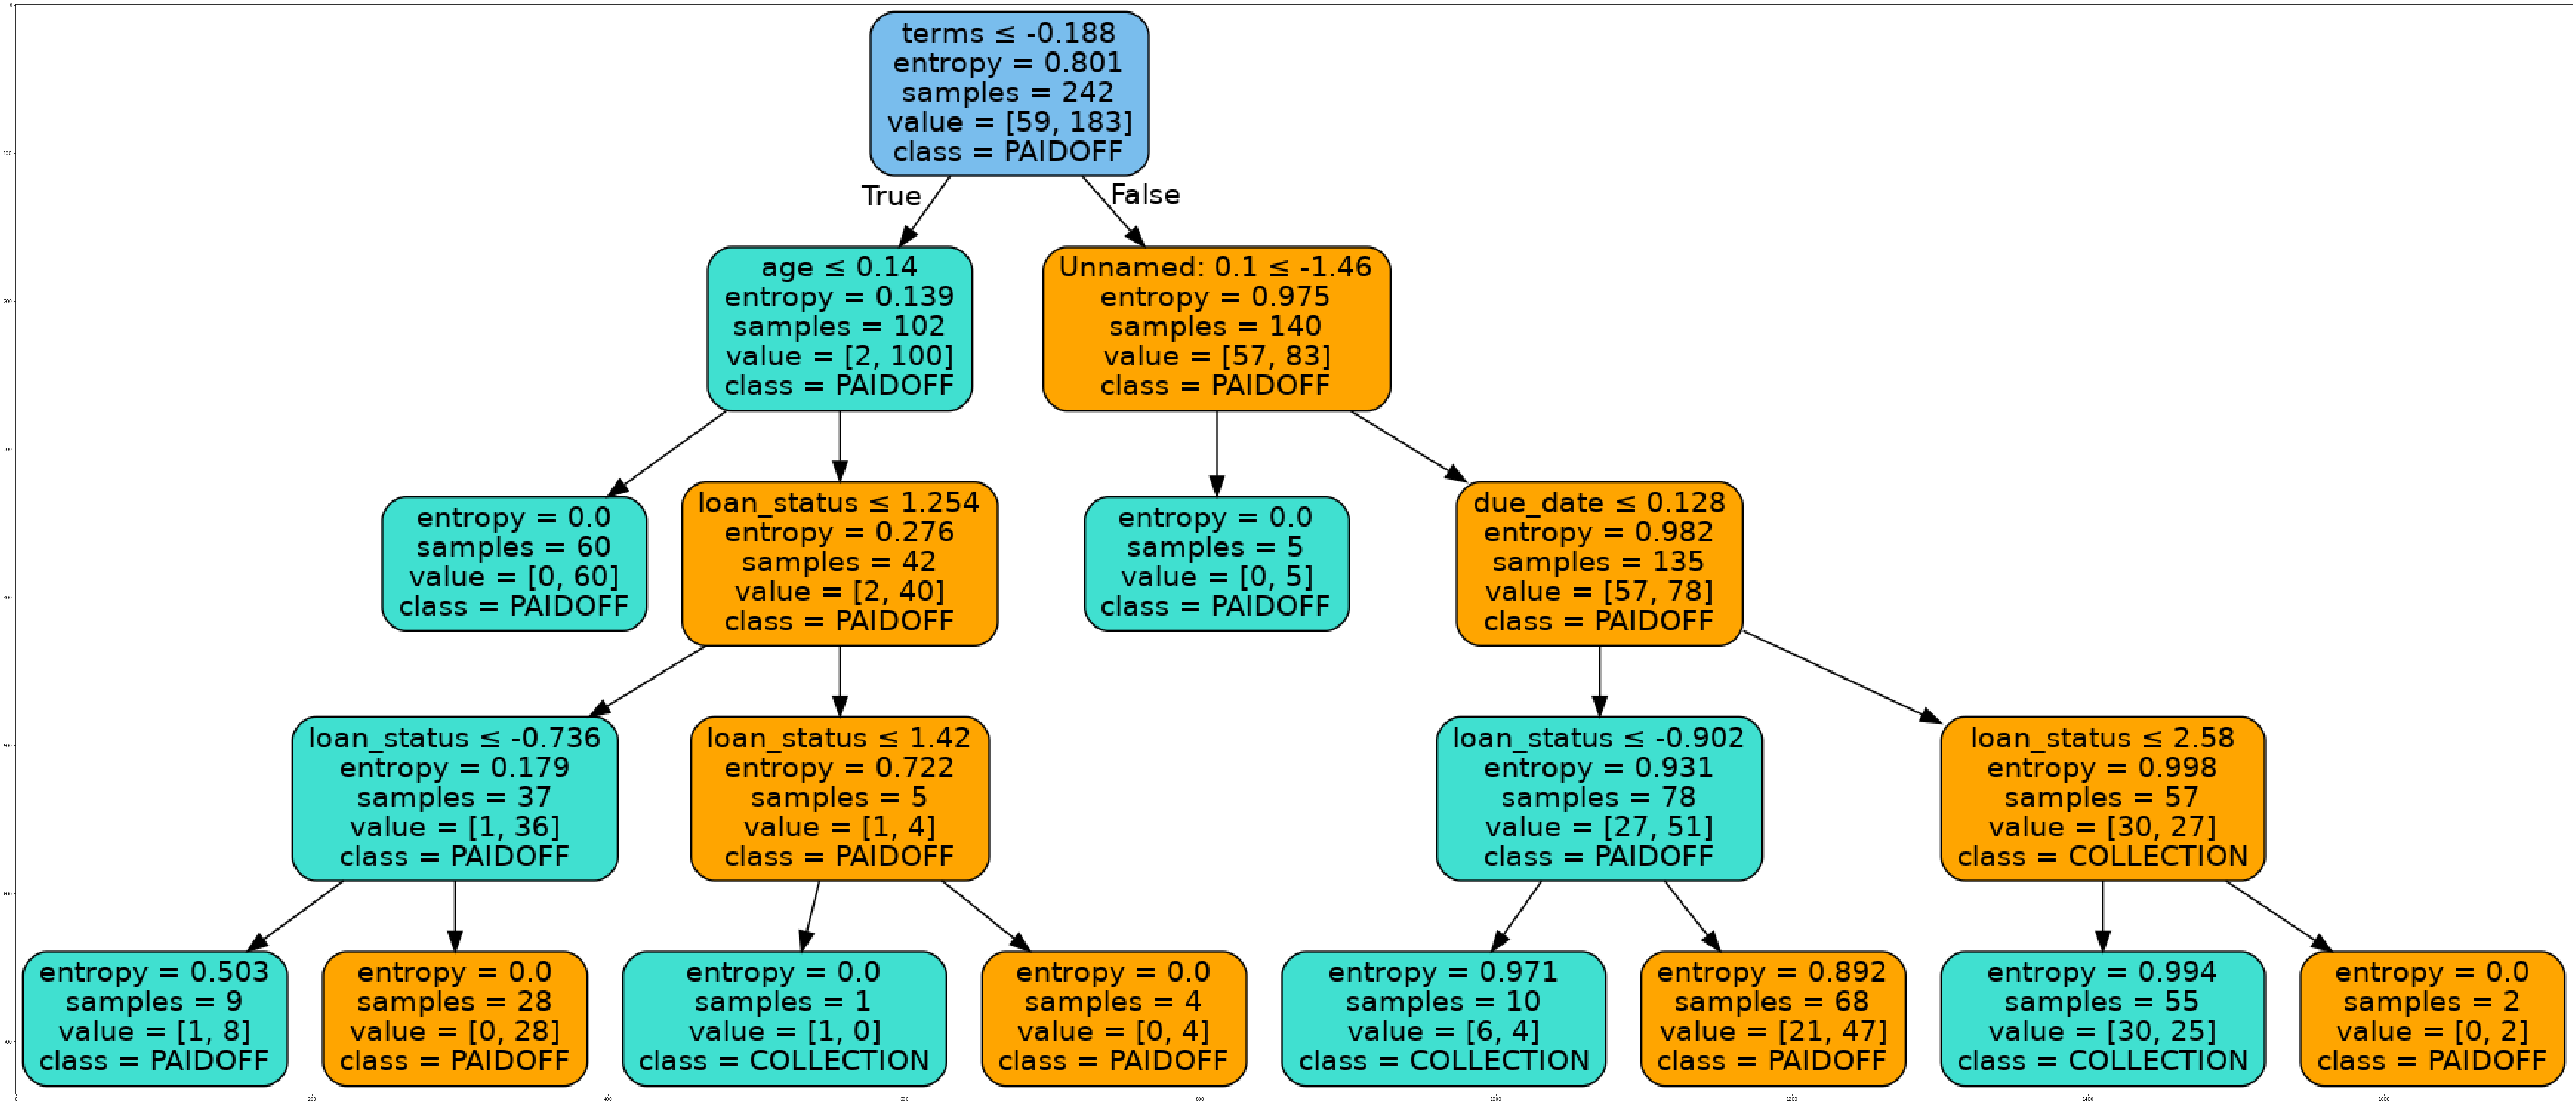

In [32]:
data_feature_names = df.columns[0:8]
data_target_names = df["loan_status"].unique().tolist()
#cn = df['loan_status']
dot_data = tree.export_graphviz(LoanTree,feature_names=data_feature_names,class_names=np.unique(y_trainset),out_file=None,filled=True,rounded=True,special_characters=True)
#dot_data = tree.export_graphviz(LoanTree,feature_names=data_feature_names,class_names=cn,out_file=None,filled=True,rounded=True)
#dot_data = tree.export_graphviz(LoanTree,feature_names=data_feature_names,out_file=None,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')
img = mpimg.imread('tree.png')
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [33]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

In [34]:
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object

In [146]:
df2 = pd.read_csv('loan_train.csv')
df2['due_date'] = pd.to_datetime(df2['due_date'])
df2['effective_date'] = pd.to_datetime(df2['effective_date'])
df2['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df2['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
#Tried to classify all education levels but this is leading to issues
#df2['education'].replace(to_replace=['High School or Below','college','Bechalor','Master or Above'], value=[0,1,2,3],inplace=True)
df2.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,1
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,0


In [147]:
df2['dayofweek'] = df2['effective_date'].dt.dayofweek
df2[['Principal','terms','age','Gender','education']].head()
df2['weekend'] = df2['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df2.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [148]:
df2.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status                int64
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object

In [376]:
#Feature2 = df2[['Principal','terms','age','Gender','weekend']]
#Drop principal from the model
Feature2 = df2[['terms','age','Gender','weekend']]
#Feature2 = df2[['age','Gender','weekend']]
Feature2 = pd.concat([Feature2,pd.get_dummies(df2['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
#Feature2 = df2[['terms','age','High School or Below','Bechalor','Gender','dayofweek','weekend']]
Feature2.head()

,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,30,45,0,0,0,1,0
1,30,33,1,0,1,0,0
2,15,27,0,0,0,0,1
3,30,28,1,1,0,0,1
4,30,29,0,1,0,0,1


In [377]:
X2 = np.asarray(Feature2)
X2 [0:5]

array([[30, 45,  0,  0,  0,  1,  0],
       [30, 33,  1,  0,  1,  0,  0],
       [15, 27,  0,  0,  0,  0,  1],
       [30, 28,  1,  1,  0,  0,  1],
       [30, 29,  0,  1,  0,  0,  1]])

In [378]:
y2 = np.asarray(df2['loan_status'])
y2[0:5]

array([1, 1, 1, 1, 1])

In [379]:
X2_train, X2_test, y2_train, y2_test = train_test_split( X2, y2, test_size=0.2,random_state=4)
print ('Train set:', X2_train.shape, y2_train.shape)
print ('Test set:', X2_test.shape, y2_test.shape)

Train set: (276, 7) (276,)
Test set: (70, 7) (70,)


In [380]:
from sklearn import svm
loan_rbf = svm.SVC(kernel='rbf')
loan_rbf.fit(X2_train, y2_train)

SVC()

In [381]:
y_rbf = loan_rbf.predict(X2_test)
y_rbf [0:5]

array([1, 1, 1, 1, 1])

In [382]:
from sklearn.metrics import f1_score
f1_score(y2_test, y_rbf, average='weighted')

0.6914285714285714

In [383]:
from sklearn.metrics import jaccard_score
jaccard_score(y2_test, y_rbf, pos_label = 1)

0.7857142857142857

In [384]:
loan_linear = svm.SVC(kernel='linear')
loan_linear.fit(X2_train, y2_train)
y_linear = loan_linear.predict(X2_test)
y_linear [0:5]
f1_score(y2_test, y_linear, average='weighted')
jaccard_score(y2_test, y_linear, pos_label = 0)
#jaccard_score(y2_test, y_linear, pos_label = 1)
print ("Linear F1 score",f1_score(y2_test, y_linear, average='weighted'))
print ("Linear Jaccard score", jaccard_score(y2_test, y_linear, pos_label = 1))

Linear F1 score 0.6914285714285714
Linear Jaccard score 0.7857142857142857


In [385]:
loan_poly = svm.SVC(kernel='poly')
loan_poly.fit(X2_train, y2_train)
y_poly = loan_poly.predict(X2_test)
y_poly [0:5]
f1_score(y2_test, y_poly, average='weighted')
jaccard_score(y2_test, y_poly, pos_label = 0)
#jaccard_score(y2_test, y_poly, pos_label = 1)
print ("Polynomial F1 score",f1_score(y2_test, y_poly, average='weighted'))
print ("Polynomial Jaccard score", jaccard_score(y2_test, y_poly, pos_label = 1))

Polynomial F1 score 0.6914285714285714
Polynomial Jaccard score 0.7857142857142857


In [386]:
loan_sigmoid = svm.SVC(kernel='sigmoid')
loan_sigmoid.fit(X2_train, y2_train)
y_sigmoid = loan_sigmoid.predict(X2_test)
y_sigmoid [0:5]
f1_score(y2_test, y_sigmoid, average='weighted')
jaccard_score(y2_test, y_sigmoid, pos_label = 0)
#jaccard_score(y2_test, y_sigmoid, pos_label = 1)
print ("Sigmoid F1 score",f1_score(y2_test, y_sigmoid, average='weighted'))
print ("Sigmoid Jaccard score", jaccard_score(y2_test, y_sigmoid, pos_label = 1))

Sigmoid F1 score 0.6978810663021189
Sigmoid Jaccard score 0.7536231884057971


In [387]:
print ("Sigmoid has best F1, others have beter Jaccard scores")

Sigmoid has best F1, others have beter Jaccard scores


# Logistic Regression

In [231]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline
import matplotlib.pyplot as plt

In [388]:
df2.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [389]:
df2.shape

(346, 12)

In [390]:
df2['loan_status'].value_counts()

1    260
0     86
Name: loan_status, dtype: int64

In [391]:
#Feature2 = df2[['terms','age','education','Gender','dayofweek','weekend']]
X2 = np.asarray(Feature2)
X2[0:5]

array([[30, 45,  0,  0,  0,  1,  0],
       [30, 33,  1,  0,  1,  0,  0],
       [15, 27,  0,  0,  0,  0,  1],
       [30, 28,  1,  1,  0,  0,  1],
       [30, 29,  0,  1,  0,  0,  1]])

In [392]:
y2 = np.asarray(df2['loan_status'])
y2[0:5]

array([1, 1, 1, 1, 1])

In [393]:
from sklearn import preprocessing
X2 = preprocessing.StandardScaler().fit(X2).transform(X2)
X2[0:5]

array([[ 0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [-0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

In [394]:
from sklearn.model_selection import train_test_split
X3_train, X3_test, y3_train, y3_test = train_test_split( X2, y2, test_size=0.5,random_state=1)
print ('Train set:', X3_train.shape, y3_train.shape)
print ('Test set:', X3_test.shape, y3_test.shape)

Train set: (173, 7) (173,)
Test set: (173, 7) (173,)


In [395]:
#Liblinear optimizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#LR_linear = LogisticRegression(C=0.01, solver='liblinear').fit(X3_train,y3_train)
LR_linear = LogisticRegression(C=0.01, solver='liblinear').fit(X3_train,y3_train)
y_LR_linear = LR_linear.predict(X3_test)
y_LR_linear_prob = LR_linear.predict_proba(X3_test)
y_LR_linear_prob

array([[0.49, 0.51],
       [0.33, 0.67],
       [0.51, 0.49],
       [0.49, 0.51],
       [0.51, 0.49],
       [0.51, 0.49],
       [0.38, 0.62],
       [0.42, 0.58],
       [0.38, 0.62],
       [0.36, 0.64],
       [0.36, 0.64],
       [0.46, 0.54],
       [0.51, 0.49],
       [0.35, 0.65],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.5 , 0.5 ],
       [0.38, 0.62],
       [0.42, 0.58],
       [0.49, 0.51],
       [0.39, 0.61],
       [0.35, 0.65],
       [0.43, 0.57],
       [0.43, 0.57],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ],
       [0.36, 0.64],
       [0.34, 0.66],
       [0.5 , 0.5 ],
       [0.46, 0.54],
       [0.43, 0.57],
       [0.44, 0.56],
       [0.35, 0.65],
       [0.31, 0.69],
       [0.48, 0.52],
       [0.37, 0.63],
       [0.35, 0.65],
       [0.5 , 0.5 ],
       [0.45, 0.55],
       [0.49, 0.51],
       [0.47, 0.53],
       [0.36, 0.64],
       [0.47, 0.53],
       [0.31, 0.69],
       [0.48, 0.52],
       [0.39, 0.61],
       [0.32, 0.68],
       [0.49,

In [396]:
from sklearn.metrics import jaccard_score
jaccard_score(y3_test, y_LR_linear, pos_label = 1)

0.7125

[[114  16]
 [ 30  13]]
Confusion matrix, without normalization
[[114  16]
 [ 30  13]]
              precision    recall  f1-score   support

           0       0.45      0.30      0.36        43
           1       0.79      0.88      0.83       130

    accuracy                           0.73       173
   macro avg       0.62      0.59      0.60       173
weighted avg       0.71      0.73      0.72       173



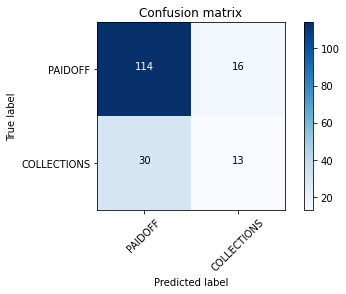

In [397]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y3_test, y_LR_linear, labels=[1,0]))
#Compute confusion matrix
cnf_matrix = confusion_matrix(y3_test, y_LR_linear, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTIONS'],normalize=False, title='Confusion matrix')
print (classification_report(y3_test, y_LR_linear))

In [398]:
from sklearn.metrics import log_loss
log_loss(y3_test, y_LR_linear_prob)

0.5929684262558483

Confusion matrix, without normalization
[[108  22]
 [ 29  14]]
              precision    recall  f1-score   support

           0       0.39      0.33      0.35        43
           1       0.79      0.83      0.81       130

    accuracy                           0.71       173
   macro avg       0.59      0.58      0.58       173
weighted avg       0.69      0.71      0.70       173

Lbfgs Jaccard score PAIDOFF 0.6792452830188679
Lbfgs Log Loss 0.6522549850837618


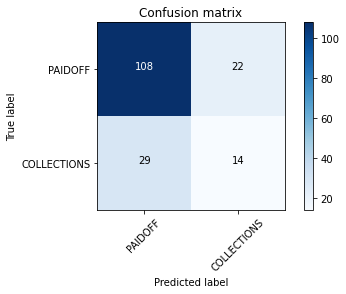

In [422]:
#Lbfgs optimizer
#LR_fgs = LogisticRegression(C=1000, solver='lbfgs').fit(X3_train,y3_train)
LR_fgs = LogisticRegression(C=1000, solver='lbfgs', multi_class='multinomial', random_state =0).fit(X3_train,y3_train)
#LR_fgs = LogisticRegression(C=1000, solver='lbfgs', multi_class='multinomial', random_state =0).fit(X3_train,y3_train)
y_LR_fgs = LR_fgs.predict(X3_test)
y_LR_fgs_prob = LR_fgs.predict_proba(X3_test)
jaccard_score(y3_test, y_LR_fgs, pos_label = 0)
jaccard_score(y3_test, y_LR_fgs, pos_label = 1)
#Compute confusion matrix
cnf_matrix = confusion_matrix(y3_test, y_LR_fgs, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTIONS'],normalize=False, title='Confusion matrix')
print (classification_report(y3_test, y_LR_fgs))
#log loss
log_loss(y3_test, y_LR_fgs_prob)
#printing
print ("Lbfgs Jaccard score PAIDOFF", jaccard_score(y3_test, y_LR_fgs, pos_label = 1))
print ("Lbfgs Log Loss",log_loss(y3_test, y_LR_fgs_prob))

Confusion matrix, without normalization
[[108  22]
 [ 29  14]]
              precision    recall  f1-score   support

           0       0.39      0.33      0.35        43
           1       0.79      0.83      0.81       130

    accuracy                           0.71       173
   macro avg       0.59      0.58      0.58       173
weighted avg       0.69      0.71      0.70       173

Newton CG Jaccard score PAIDOFF 0.6792452830188679
Newton CG Loss 0.6521258283656732


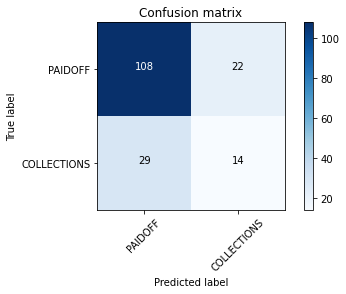

In [423]:
#Newton-cg optimizer
LR_ncg = LogisticRegression(C=1000, solver='newton-cg',multi_class='multinomial', random_state =0).fit(X3_train,y3_train)
y_LR_ncg = LR_ncg.predict(X3_test)
y_LR_ncg_prob = LR_ncg.predict_proba(X3_test)
jaccard_score(y3_test, y_LR_ncg, pos_label = 0)
jaccard_score(y3_test, y_LR_ncg, pos_label = 1)
#Compute confusion matrix
cnf_matrix = confusion_matrix(y3_test, y_LR_ncg, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTIONS'],normalize=False, title='Confusion matrix')
print (classification_report(y3_test, y_LR_ncg))
#log loss
log_loss(y3_test, y_LR_ncg_prob)
#printing
print ("Newton CG Jaccard score PAIDOFF", jaccard_score(y3_test, y_LR_ncg, pos_label = 1))
print ("Newton CG Loss",log_loss(y3_test, y_LR_ncg_prob))

Confusion matrix, without normalization
[[108  22]
 [ 29  14]]
              precision    recall  f1-score   support

           0       0.39      0.33      0.35        43
           1       0.79      0.83      0.81       130

    accuracy                           0.71       173
   macro avg       0.59      0.58      0.58       173
weighted avg       0.69      0.71      0.70       173

Saga Jaccard score PAIDOFF 0.6792452830188679
Saga Log Loss 0.6331991839294001


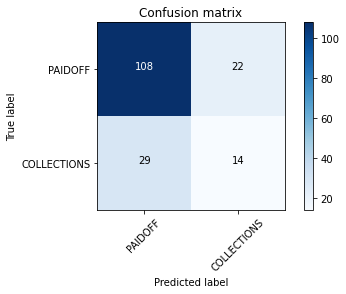

In [424]:
#Saga optimizer
LR_saga = LogisticRegression(C=1000, solver='saga',max_iter=1000,multi_class='multinomial', random_state =0).fit(X3_train,y3_train)
y_LR_saga = LR_saga.predict(X3_test)
y_LR_saga_prob = LR_saga.predict_proba(X3_test)
jaccard_score(y3_test, y_LR_saga, pos_label = 0)
jaccard_score(y3_test, y_LR_saga, pos_label = 1)
#Compute confusion matrix
cnf_matrix = confusion_matrix(y3_test, y_LR_saga, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTIONS'],normalize=False, title='Confusion matrix')
print (classification_report(y3_test, y_LR_saga))
#log loss
log_loss(y3_test, y_LR_saga_prob)
#printing
print ("Saga Jaccard score PAIDOFF", jaccard_score(y3_test, y_LR_saga, pos_label = 1))
print ("Saga Log Loss",log_loss(y3_test, y_LR_saga_prob))

Confusion matrix, without normalization
[[108  22]
 [ 29  14]]
              precision    recall  f1-score   support

           0       0.39      0.33      0.35        43
           1       0.79      0.83      0.81       130

    accuracy                           0.71       173
   macro avg       0.59      0.58      0.58       173
weighted avg       0.69      0.71      0.70       173

Saga Jaccard score PAIDOFF 0.6792452830188679
Saga Log Loss 0.6269617329499984


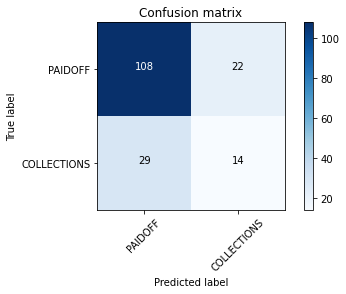

In [425]:
#Sag optimizer
LR_sag = LogisticRegression(C=1000, solver='sag', random_state =0,max_iter=1000).fit(X3_train,y3_train)
y_LR_sag = LR_sag.predict(X3_test)
y_LR_sag_prob = LR_sag.predict_proba(X3_test)
jaccard_score(y3_test, y_LR_sag, pos_label = 0)
jaccard_score(y3_test, y_LR_sag, pos_label = 1)
#Compute confusion matrix
cnf_matrix = confusion_matrix(y3_test, y_LR_sag, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTIONS'],normalize=False, title='Confusion matrix')
print (classification_report(y3_test, y_LR_sag))
#log loss
log_loss(y3_test, y_LR_sag_prob)
#printing
print ("Saga Jaccard score PAIDOFF", jaccard_score(y3_test, y_LR_sag, pos_label = 1))
print ("Saga Log Loss",log_loss(y3_test, y_LR_sag_prob))

In [426]:
print ("Lbfgs with a high C has the best log loss")

Lbfgs with a high C has the best log loss


# Model Evaluation using Test set

In [261]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [276]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-12-19 03:14:34--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-12-19 03:14:34 (94.8 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [277]:
test_df = pd.read_csv('loan_test.csv')
test_df2 = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [278]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [279]:
test_df.shape
test_df2.shape
print (test_df.shape)
print (test_df2.shape)

(54, 10)
(54, 10)


In [280]:
#first we need to reformat test_df for consistency with df (which has status as PAIDOFF AND COLLECITONS) and df2 which has it as 0 and 1
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()
print ("first test set",test_df.head())
#second set.  I know the original example converted education into a binary with 0 = high school or below and 1 = everything else.  I wanted to see the impacts of keeping education as it was
test_df2['due_date'] = pd.to_datetime(test_df2['due_date'])
test_df2['effective_date'] = pd.to_datetime(test_df2['effective_date'])
test_df2['dayofweek'] = test_df2['effective_date'].dt.dayofweek
test_df2['weekend'] = test_df2['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df2['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df2['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True)
#test_df2['education'].replace(to_replace=['High School or Below','college','Bechalor','Master or Above'], value=[0,1,2,3],inplace=True)
#do not do this extra speciation for education
test_df2.head()
print ("second test set",test_df2.head())

first test set    Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30     2016-09-08   
1           5             5     PAIDOFF        300      7     2016-09-09   
2          21            21     PAIDOFF       1000     30     2016-09-10   
3          24            24     PAIDOFF       1000     30     2016-09-10   
4          35            35     PAIDOFF        800     15     2016-09-11   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   50              Bechalor       1          3        0  
1 2016-09-15   35       Master or Above       0          4        1  
2 2016-10-09   43  High School or Below       1          5        1  
3 2016-10-09   26               college       0          5        1  
4 2016-09-25   29              Bechalor       0          6        1  
second test set    Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0           1  

In [281]:
print (test_df.shape)
print (test_df2.shape)

(54, 12)
(54, 12)


In [282]:
#one hot encoding
test_df[['Principal','terms','age','Gender','education']].head()
test_df2[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [283]:
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature.head()
test_X = test_Feature
test_X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [284]:
test_X.shape

(54, 8)

In [285]:
test_Feature.shape

(54, 8)

In [374]:
#test_Feature2 = test_df2[['Principal','terms','age','Gender','weekend']]
#SVM  did better without Principal and terms factored into the model
#test_Feature2 = test_df2[['age','Gender','weekend']]
test_Feature2 = test_df2[['terms','age','Gender','weekend']]
test_Feature2 = pd.concat([test_Feature2,pd.get_dummies(test_df2['education'])], axis=1)
test_Feature2.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature2.head()
test_X2 = np.asarray(test_Feature2)
test_X2[0:5]

array([[30, 50,  1,  0,  1,  0,  0],
       [ 7, 35,  0,  1,  0,  0,  0],
       [30, 43,  1,  1,  0,  1,  0],
       [30, 26,  0,  1,  0,  0,  1],
       [15, 29,  0,  1,  1,  0,  0]])

In [427]:
test_X2.shape

(54, 7)

In [333]:
test_y = test_df['loan_status'].values
test_y[0:5]
print ("First test set",test_y[0:5])
test_y2 = np.asarray(test_df2['loan_status'])
test_y2[0:5]
print ("Second test set",test_y2[0:5])

First test set ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Second test set [1 1 1 1 1]


In [334]:
#ok now that the formatting is out of the way, let's do KNN first
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [335]:
#KNN Train Model and Predict
print ('Train set:', X.shape, y.shape)
print ('Test set:', test_X.shape, test_y.shape)
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)
neigh
print (neigh)
y_knn = neigh.predict(test_X)
y_knn[0:5]
print (y_knn[0:5])
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y, neigh.predict(X)))
print("Test set Accuracy: ", metrics.accuracy_score(test_y, y_knn))
f1_score(test_y, y_knn, average='weighted')
print("KNN Model F1 Score, k=7: ", f1_score(test_y, y_knn, average='weighted'))
jaccard_score(test_y, y_knn, pos_label = "PAIDOFF")
jaccard_score(test_y, y_knn, pos_label = "COLLECTION")
print("Jaccard score PAIDOFF: ", jaccard_score(test_y, y_knn, pos_label = "PAIDOFF"))

Train set: (346, 8) (346,)
Test set: (54, 8) (54,)
KNeighborsClassifier(n_neighbors=7)
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION']
Train set Accuracy:  0.8092485549132948
Test set Accuracy:  0.7222222222222222
KNN Model F1 Score, k=7:  0.7001989201477693
Jaccard score PAIDOFF:  0.7


In [433]:
#Decision Tree Train Model and Predict
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
print ('Train set:', X.shape, y.shape)
print ('Test set:', test_X.shape, test_y.shape)
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
tree # it shows the default parameter
tree.fit(X,y)
y_tree = tree.predict(test_X)
print (y_tree [0:5])
print (test_y [0:5])
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(test_y, y_tree))
f1_score(test_y, y_tree, average='weighted')
print("Decition Tree Model F1 Score, Entropy: 4", f1_score(test_y, y_tree, average='weighted'))
jaccard_score(test_y, y_tree, pos_label = "PAIDOFF")
jaccard_score(test_y, y_tree, pos_label = "COLLECTION")
print("Jaccard score PAIDOFF: ", jaccard_score(test_y, y_tree, pos_label = "PAIDOFF"))

Train set: (346, 8) (346,)
Test set: (54, 8) (54,)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
DecisionTrees's Accuracy:  0.7777777777777778
Decition Tree Model F1 Score, Entropy: 4 0.7283950617283951
Jaccard score PAIDOFF:  0.7647058823529411


In [135]:
print("scores slightly better at Entropy 4 than just using a test/train set out of the train set")

scores slightly better at Entropy 4 than just using a test/train set out of the train set


In [428]:
#Ok now to SVM - We use the second set since Loan status is binary for this evalution
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import preprocessing
X2 = preprocessing.StandardScaler().fit(X2).transform(X2)
X2[0:5]

array([[ 0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [-0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

In [429]:
#Sigmoid did the best in evaluating the train set
print ('Train set:', X2.shape, y2.shape)
print ('Test set:', test_X2.shape, test_y2.shape)
svm_sigmoid = svm.SVC(kernel='sigmoid')
svm_sigmoid.fit(X2, y2)
y_sigmoid2 = svm_sigmoid.predict(test_X2)
y_sigmoid2 
print (y_sigmoid2)
f1_score(test_y2, y_sigmoid2, average='weighted')
jaccard_score(test_y2, y_sigmoid2, pos_label = 0)
jaccard_score(test_y2, y_sigmoid2, pos_label = 1)
print ("Sigmoid F1 score",f1_score(test_y2, y_sigmoid2, average='weighted'))
print ("Sigmoid Jaccard score PAIDOFF", jaccard_score(test_y2, y_sigmoid2, pos_label = 1))

Train set: (346, 7) (346,)
Test set: (54, 7) (54,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Sigmoid F1 score 0.6304176516942475
Sigmoid Jaccard score PAIDOFF 0.7407407407407407


In [430]:
#Last up - Logistic
from sklearn.metrics import log_loss
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline
import matplotlib.pyplot as plt

Train set: (346, 7) (346,)
Test set: (54, 7) (54,)
Confusion matrix, without normalization
[[19 21]
 [ 6  8]]
              precision    recall  f1-score   support

           0       0.28      0.57      0.37        14
           1       0.76      0.47      0.58        40

    accuracy                           0.50        54
   macro avg       0.52      0.52      0.48        54
weighted avg       0.63      0.50      0.53        54

Lbfgs Jaccard score PAIDOFF 0.41304347826086957
Lbfgs Loss 0.8164437481457382


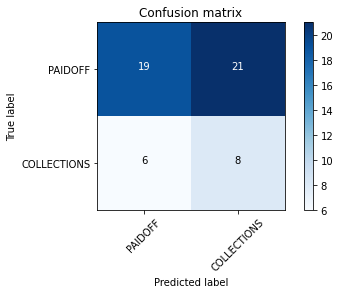

In [431]:
print ('Train set:', X2.shape, y2.shape)
print ('Test set:', test_X2.shape, test_y2.shape)
#Lbfgs did the best on just the train set
#Lbfgs optimizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR_fgs2 = LogisticRegression(C=500, solver='lbfgs', multi_class='multinomial', random_state =0,max_iter=1000).fit(X2,y2)
#LR_fgs2 = LogisticRegression(C=.02, solver='lbfgs'). fit(X2,y2)
y_LR_fgs2 = LR_fgs2.predict(test_X2)
y_LR_fgs2_prob = LR_fgs2.predict_proba(test_X2)
jaccard_score(test_y2, y_LR_fgs2, pos_label = 0)
jaccard_score(test_y2, y_LR_fgs2, pos_label = 1)
#Compute confusion matrix
cnf_matrix = confusion_matrix(test_y2, y_LR_fgs2, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTIONS'],normalize=False, title='Confusion matrix')
print (classification_report(test_y2, y_LR_fgs2))
#log loss
log_loss(test_y2, y_LR_fgs2_prob)
#printing
print ("Lbfgs Jaccard score PAIDOFF", jaccard_score(test_y2, y_LR_fgs2, pos_label = 1))
print ("Lbfgs Loss",log_loss(test_y2, y_LR_fgs2_prob))

In [145]:
print("about 50% correct prediction - good indexes")

about 50% correct prediction - good indexes


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.70    | 0.70     | NA      |
| Decision Tree      | 0.73    | 0.76     | NA      |
| SVM                | 0.74    | 0.63     | NA      |
| LogisticRegression | 0.41    | 0.53     | 0.82    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>